In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist.data, mnist.target

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

(None, '5')

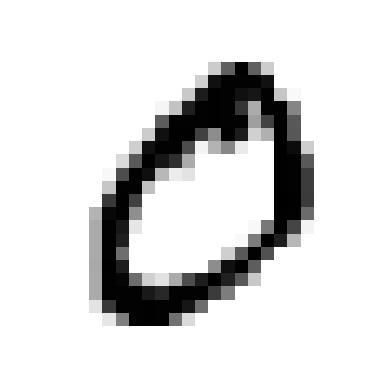

In [5]:
from matplotlib import pyplot as plt

def show_digit(digit):
    image = digit.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

show_digit(X[1]), y[0]

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5, y_test_5 = (y_train == '5'), (y_test == '5')
y_test_5, y_train_5

(array([False, False, False, ..., False,  True, False]),
 array([ True, False, False, ...,  True, False, False]))

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(n_jobs=-1)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(n_jobs=-1)

In [9]:
sgd_classifier.predict([X[1]])

array([False])

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=5, n_jobs=-1, scoring="accuracy")

array([0.97108333, 0.96366667, 0.95933333, 0.96225   , 0.97066667])

In [11]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train_5)

DummyClassifier(strategy='most_frequent')

In [12]:
cross_val_score(dummy_classifier, X_train, y_train_5, scoring="accuracy", cv=3, n_jobs=-1)

array([0.90965, 0.90965, 0.90965])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is
 # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_classifier)
 X_train_folds = X_train[train_index]
 y_train_folds = y_train_5[train_index]
 X_test_fold = X_train[test_index]
 y_test_fold = y_train_5[test_index]
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) # prints 0.95035, 0.96035, and 0.9604

0.96435
0.9651
0.962


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_5_cv_preds = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [15]:
cf_matrix = confusion_matrix(y_train_5, y_train_5_cv_preds)
cf_matrix

array([[53816,   763],
       [ 1533,  3888]])

In [16]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [17]:
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_train_5, y_train_5_cv_preds)
precission = precision_score(y_train_5, y_train_5_cv_preds)
recall, precission

(0.7172108467072495, 0.8359492582240379)

In [19]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_5_cv_preds)
f1

0.7720413026211279

In [35]:
y_scores = sgd_classifier.decision_function(X_train)
treshold = -3000

y_preds_5_treshold = (y_scores > treshold)

f1 = f1_score(y_train_5, y_preds_5_treshold)
precision = precision_score(y_train_5, y_preds_5_treshold)
recall = recall_score(y_train_5, y_preds_5_treshold)

print(f"f1: {f1} precission: {precision} recall: {recall}")

f1: 0.8038945373082889 precission: 0.7542441390460792 recall: 0.8605423353624793


In [37]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

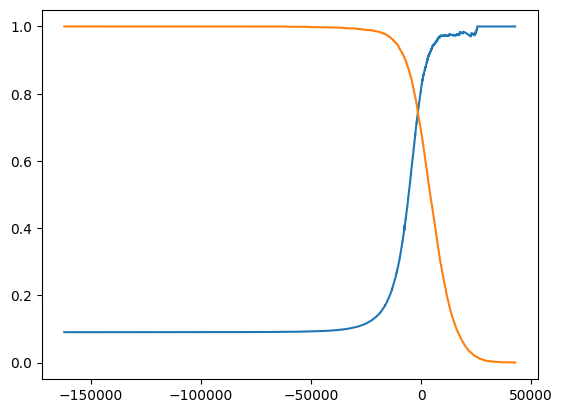

In [56]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, tresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(tresholds, precisions[:-1])
plt.plot(tresholds, recalls[:-1])

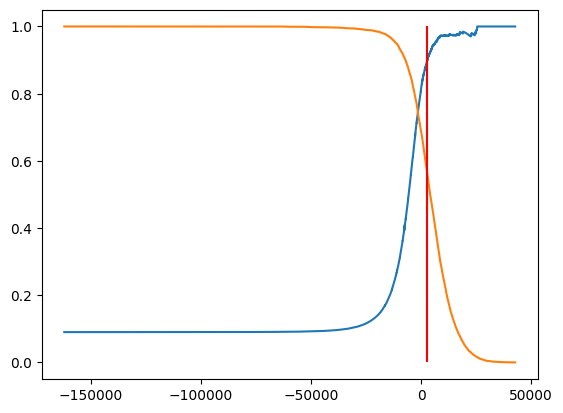

In [55]:
idx_for_90_precision = (precisions >= 0.9).argmax()
treshold_for_90_precision = tresholds[idx_for_90_precision]

plt.plot(tresholds, precisions[:-1])
plt.plot(tresholds, recalls[:-1])
plt.vlines(treshold_for_90_precision, 0, 1, "r")

In [60]:
y_train_5_preds = (y_scores >= treshold_for_90_precision)
precision_score(y_train_5, y_train_5_preds), recall_score(y_train_5, y_train_5_preds)

(0.9001477104874446, 0.5620734181885261)

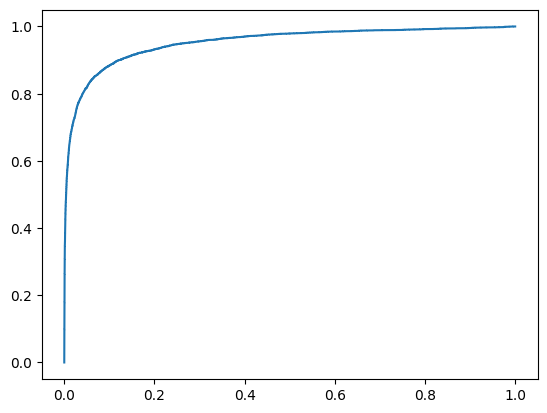

In [62]:
from sklearn.metrics import roc_curve

fpr, tpr, tresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr)

In [63]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9525909649559864

In [70]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, n_jobs=-1, method="predict_proba")

In [71]:
y_probs_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [75]:
y_scores_forest = y_probs_forest[:, [1]]
y_scores_forest

array([[0.89],
       [0.01],
       [0.04],
       ...,
       [0.98],
       [0.08],
       [0.06]])

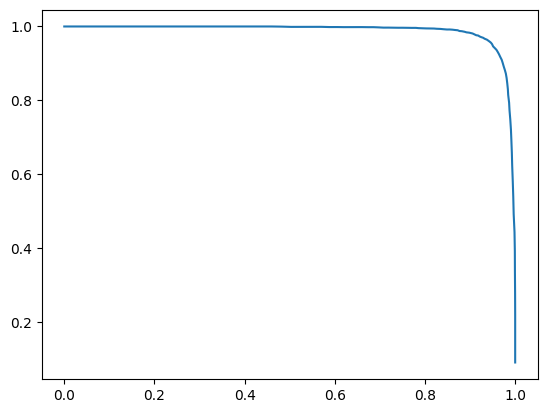

In [79]:
precission_forest, recall_forest, treshold_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recall_forest, precission_forest)


In [85]:
y_preds_forest = (y_scores_forest > 0.5)

f1_score(y_train_5, y_preds_forest), roc_auc_score(y_train_5, y_preds_forest)

(0.9242275142688448, 0.9327181722735077)

In [ ]:
from sklearn.svm import SVC

svc_clf = SVC(random_state=42)
svc_clf.fit(X_train, y_train, n)